In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import torchmetrics

from flamekit.training import TorchTrainer
from flamekit.devices import select_device, print_cuda_available_devices
from flamekit.callbacks import TorchMetricsEvaluator
from flamekit.pbars import TQDMProgressBar
from flamekit.sampling import split_dataset, CustomSequentialSampler, CustomRandomSampler
from flamekit.utils import setup_reproducible_env, get_next_experiment_path

In [2]:
seed = 1337
checkpoints_dir = './checkpoints'

n_classes = 10
task = 'multiclass'
average = 'macro'

epochs = 10
batch_size = 128

In [3]:
setup_reproducible_env(seed=seed)
exp_path = get_next_experiment_path(checkpoints_dir)
print("Experiments Directory:", exp_path)

Experiments Directory: checkpoints\experiment_1


In [4]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, val_indices, test_indices = split_dataset(trainset, val_split=0.2, test_split=0)
train_sampler = CustomRandomSampler(train_indices)
val_sampler = CustomSequentialSampler(val_indices)

# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

print("Training Samples:", len(train_indices), "| Batches:", len(train_loader))
print("Val Samples:", len(val_indices), "| Batches:", len(val_loader))
print("Test Samples:", len(testset), "| Batches:", len(test_loader))

Training Samples: 48000 | Batches: 375
Val Samples: 12000 | Batches: 94
Test Samples: 10000 | Batches: 79


In [18]:
print_cuda_available_devices()
device = select_device(index=0, cuda=True)
print("Selected Device:", device)

Available CUDA devices:
+-------+-------------------------------------------+
| Index |                Device Name                |
+-------+-------------------------------------------+
|   0   | NVIDIA GeForce GTX 1650 with Max-Q Design |
+-------+-------------------------------------------+
Selected Device: cuda:0


In [5]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Instantiate the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train Model

In [8]:
trainer = TorchTrainer(model, device)
trainer.compile(optimizer, criterion=criterion)

In [9]:
class MNISTEvaluator(TorchMetricsEvaluator):
    
    def calc_step_metrics(self, trainer, model, outputs, labels, stage, batch_idx) -> list[tuple]:
        outputs = outputs.argmax(dim=1)
        return super().calc_step_metrics(trainer, model, outputs, labels, stage, batch_idx)

In [10]:
evaluator = MNISTEvaluator()

step_metrics = {
    'acc': torchmetrics.Accuracy(task=task, num_classes=n_classes, average=average),
}
epoch_metrics = {
    'precision': torchmetrics.Precision(task=task, num_classes=n_classes, average=average),
    'recall': torchmetrics.Recall(task=task, num_classes=n_classes, average=average),
    'f1': torchmetrics.F1Score(task=task, num_classes=n_classes, average=average),
    'auc': torchmetrics.AUROC(task=task, num_classes=n_classes, average=average),
}
evaluator.add_step_metrics(step_metrics)
evaluator.add_epoch_metric(epoch_metrics)

pbar = TQDMProgressBar(show_remaining_time=False, show_rate=False)
callbacks = [evaluator, pbar]

history = trainer.fit(
    train_loader,
    validation_loader=val_loader,
    epochs=epochs,
    dest_path=exp_path,
    monitor='val_loss',
    prefix=model.__class__.__name__,
    save_best=True,
    callbacks=callbacks
)

Epoch 1/10: 100% |██████████████████████████████| 375/375 [00:34, loss=0.499, acc=0.855, auc=0.985, f1=0.854, precision=0.855, recall=0.854, val_loss=0.284, val_acc=0.916, val_auc=0.994, val_f1=0.916, val_precision=0.918, val_recall=0.915]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_1\SimpleNN_val-loss_0.2841_1_best.tar)


Epoch 2/10: 100% |██████████████████████████████| 375/375 [00:24, loss=0.245, acc=0.927, auc=0.995, f1=0.927, precision=0.927, recall=0.927, val_loss=0.213, val_acc=0.934, val_auc=0.997, val_f1=0.935, val_precision=0.937, val_recall=0.935]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_1\SimpleNN_val-loss_0.2129_2_best.tar)


Epoch 3/10: 100% |██████████████████████████████| 375/375 [00:22, loss=0.181, acc=0.946, auc=0.997, f1=0.946, precision=0.946, recall=0.946, val_loss=0.189, val_acc=0.94, val_auc=0.998, val_f1=0.941, val_precision=0.943, val_recall=0.941]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_1\SimpleNN_val-loss_0.1887_3_best.tar)


Epoch 4/10: 100% |██████████████████████████████| 375/375 [00:25, loss=0.146, acc=0.956, auc=0.998, f1=0.957, precision=0.957, recall=0.957, val_loss=0.163, val_acc=0.948, val_auc=0.998, val_f1=0.948, val_precision=0.95, val_recall=0.948]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_1\SimpleNN_val-loss_0.1631_4_best.tar)


Epoch 5/10: 100% |██████████████████████████████| 375/375 [00:26, loss=0.123, acc=0.963, auc=0.999, f1=0.963, precision=0.963, recall=0.963, val_loss=0.14, val_acc=0.956, val_auc=0.999, val_f1=0.957, val_precision=0.957, val_recall=0.956]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_1\SimpleNN_val-loss_0.1397_5_best.tar)


Epoch 6/10: 100% |██████████████████████████████| 375/375 [00:29, loss=0.104, acc=0.967, auc=0.999, f1=0.968, precision=0.968, recall=0.968, val_loss=0.123, val_acc=0.963, val_auc=0.999, val_f1=0.963, val_precision=0.963, val_recall=0.963]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_1\SimpleNN_val-loss_0.1232_6_best.tar)


Epoch 7/10: 100% |██████████████████████████████| 375/375 [00:32, loss=0.0885, acc=0.972, auc=0.999, f1=0.972, precision=0.972, recall=0.972, val_loss=0.104, val_acc=0.968, val_auc=0.999, val_f1=0.968, val_precision=0.968, val_recall=0.968]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_1\SimpleNN_val-loss_0.1038_7_best.tar)


Epoch 8/10: 100% |██████████████████████████████| 375/375 [00:28, loss=0.078, acc=0.975, auc=0.999, f1=0.976, precision=0.976, recall=0.976, val_loss=0.123, val_acc=0.963, val_auc=0.999, val_f1=0.963, val_precision=0.964, val_recall=0.963]
Epoch 9/10: 100% |██████████████████████████████| 375/375 [00:24, loss=0.0736, acc=0.977, auc=1, f1=0.977, precision=0.976, recall=0.977, val_loss=0.107, val_acc=0.969, val_auc=0.999, val_f1=0.968, val_precision=0.969, val_recall=0.968]
Epoch 10/10: 100% |██████████████████████████████| 375/375 [00:28, loss=0.0642, acc=0.979, auc=1, f1=0.979, precision=0.979, recall=0.979, val_loss=0.11, val_acc=0.966, val_auc=0.999, val_f1=0.967, val_precision=0.967, val_recall=0.967]

[INFO] Saving last checkpoint of the training to 'checkpoints\experiment_1\SimpleNN_val-loss_0.1104_10_last.tar'


Plot training metrics

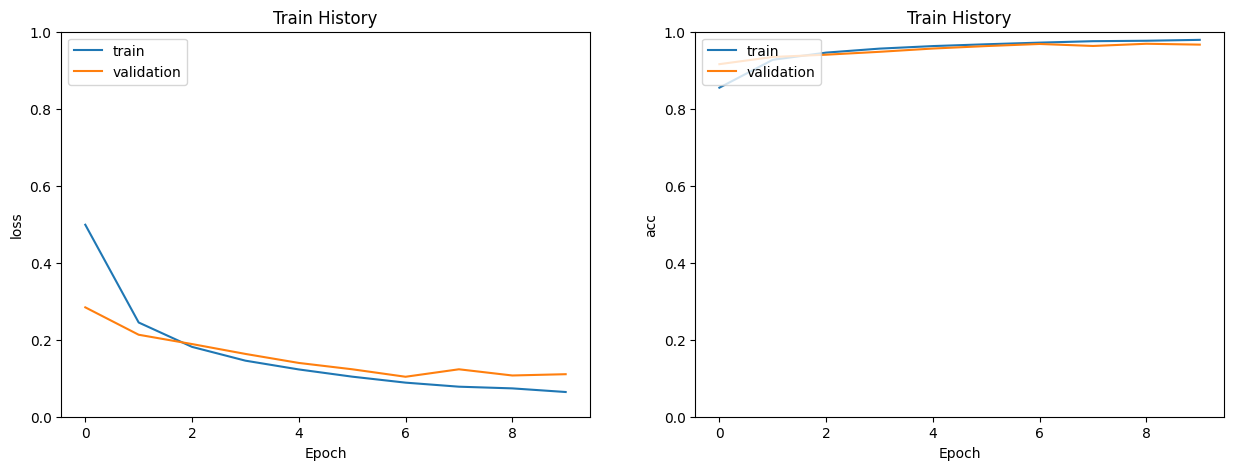

In [11]:
trainer.plot(metrics=['loss', 'acc'])

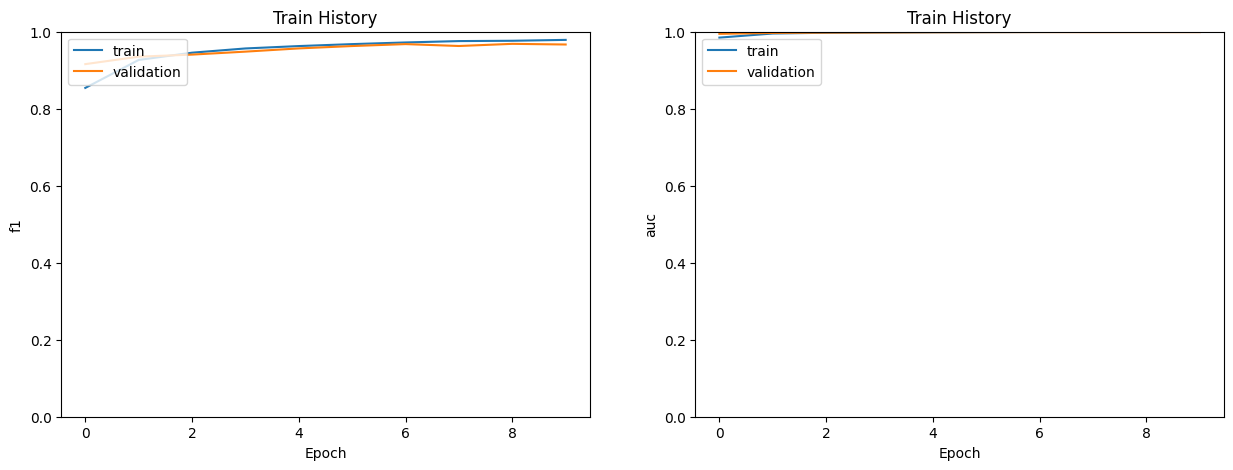

In [12]:
trainer.plot(metrics=['f1', 'auc'])

Load best checkpoint

In [13]:
trainer.load_best()

[OK] Checkpoint 'checkpoints\experiment_1\SimpleNN_val-loss_0.1038_7_best.tar' has been loaded successfully


Evaluate on testset

In [14]:
trainer.predict(test_loader, callbacks=callbacks)

Predicting: 100% |██████████████████████████████| 79/79 [00:05, loss=0.0998, acc=0.969, auc=0.999, f1=0.969, precision=0.969, recall=0.969]
